In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from EntropyHub import ApEn
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from warnings import filterwarnings
filterwarnings("ignore")

# MINI CHALLENGE: Hotels Revenue

From a dataset containing 7 years of the hotel demand and revenue of different major cities of the US, the goal was to being able to produce 1-7 days ahead forecast of the Revenue column of a particular city, which we decided to be Washington

## EXPLORATORY ANALYSIS

At first, we loaded the data and selected Washington as the city of interest

In [193]:
df = pd.read_pickle("hotels.pk")
df.reset_index(inplace=True)

washington_df = df[(df["Location"] == "Washington") & (df["Date"] < "2019-12-31") ]
washington_df.drop(columns=["Location"], inplace=True)

Then we checked for the presence of null/duplicated values

In [194]:
print("Null values: ", washington_df.isna().sum().sum())
print("Duplicated values: ", washington_df.duplicated().sum().sum())
washington_df.describe()

Null values:  0
Duplicated values:  0


,Revenue,Demand,Occupancy
count,2.555000e+03,2555.000000,2555.000000
mean,1.615843e+06,14082.483549,68.539858
std,5.579383e+05,3258.926472,15.549966
min,4.066405e+05,4851.539368,24.402264
25%,1.204515e+06,11732.050018,57.409626
50%,1.586524e+06,14449.717496,70.750103
75%,1.987437e+06,16692.255177,81.040925
max,3.974323e+06,21098.828513,97.685409


Once ensured of proper data integrity, we decided to plot the revenue column. We were able to observe the presence of a few global outliers, reasons of which are unknown, and also evident annual seasonality with a slight increasing trend.

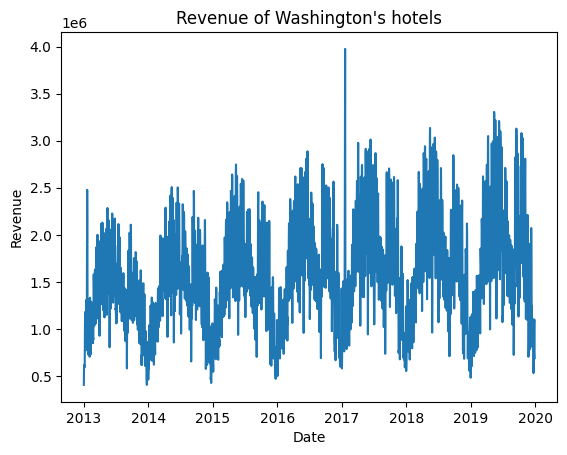

In [195]:
plt.plot(washington_df.Date, washington_df.Revenue)
plt.title("Revenue of Washington's hotels")
plt.xlabel("Date")
plt.ylabel("Revenue");

To remove such outliers, we implemented a rolling window approach which takes a few (30) samples and removes values outside of the +- 2.5 standard deviations. 

In [196]:
def get_outliers():
    window_size = 30

    rolling_mean = washington_df.Revenue.rolling(window=window_size, center=True).mean()

    rolling_std = washington_df.Revenue.rolling(window=window_size, center=True).std()

    mult = 2.5
    upper_bound = rolling_mean + mult * rolling_std
    lower_bound = rolling_mean - mult * rolling_std

    outliers = (washington_df.Revenue > upper_bound) | (washington_df.Revenue < lower_bound)
    return outliers

outliers = get_outliers()
df_filtered = washington_df[~outliers]
print("Number of outliers removed: ", washington_df.shape[0] - outliers.value_counts()[0])

Number of outliers removed:  5


To understand the effects of outliers removal, below the plots of before/after their removal

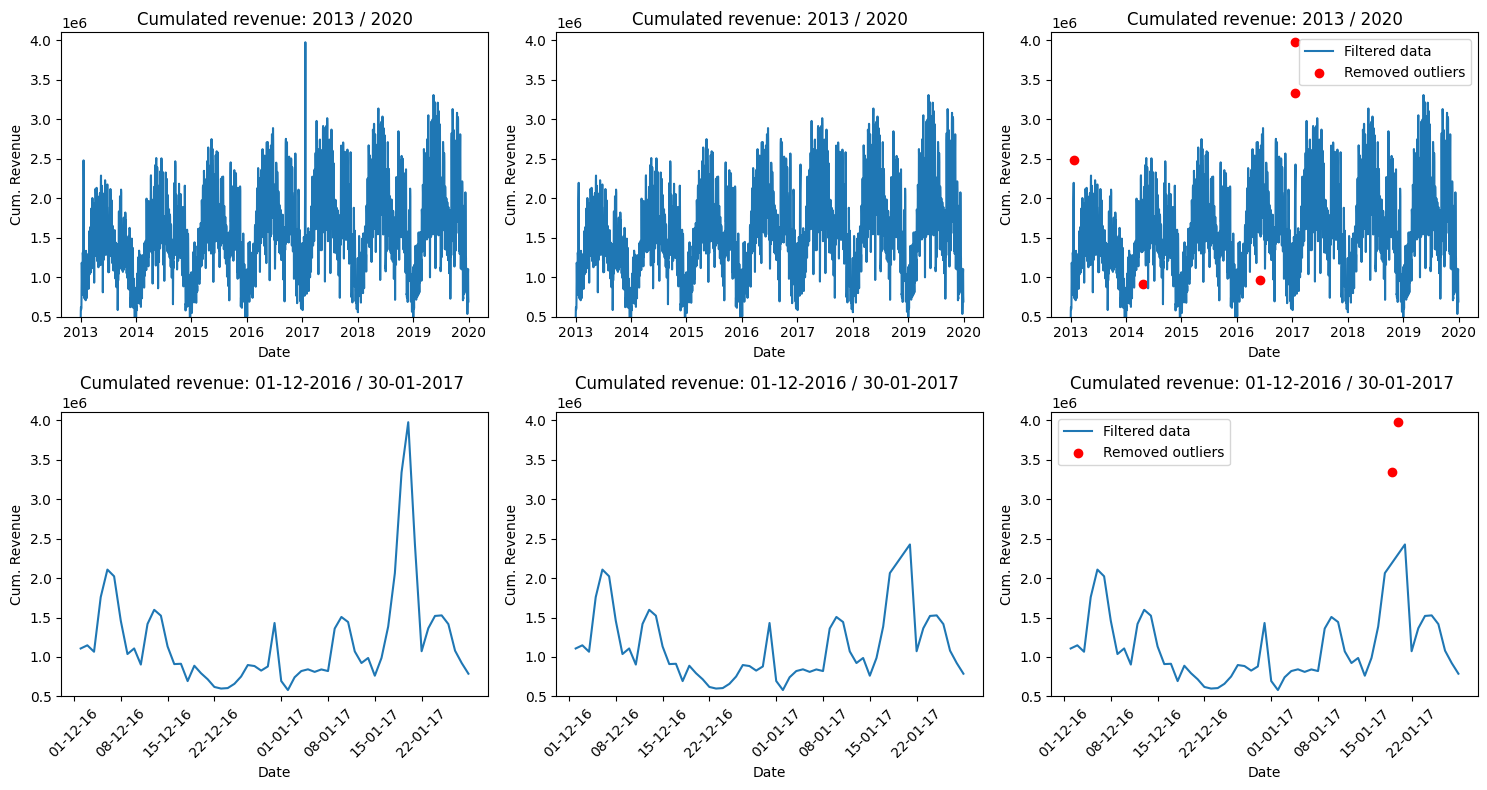

In [197]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
ax[0, 0].plot(washington_df.Date, washington_df.Revenue)
ax[0, 1].plot(df_filtered.Date, df_filtered.Revenue)
ax[0, 2].plot(df_filtered.Date, df_filtered.Revenue, label="Filtered data")
ax[0, 2].scatter(washington_df[outliers].Date, washington_df[outliers].Revenue, color="red", label="Removed outliers")
ax[0, 2].legend()

start_date, end_date, date_format = '2016-12-01', '2017-01-30', '%d-%m-%y'
temp_df = washington_df[(washington_df.Date > start_date) & (washington_df.Date < end_date)]
temp_df_filtered = df_filtered[(df_filtered.Date > start_date) & (df_filtered.Date < end_date)]

ax[1, 0].plot(temp_df.Date, temp_df.Revenue)
ax[1, 1].plot(temp_df_filtered.Date, temp_df_filtered.Revenue)
ax[1, 2].plot(temp_df_filtered.Date, temp_df_filtered.Revenue, label="Filtered data")
ax[1, 2].scatter(temp_df[outliers].Date, temp_df[outliers].Revenue, color="red", label="Removed outliers")
ax[1, 2].legend()


for i in range(3):
    ax[0, i].set_xlabel('Date')
    ax[0, i].set_ylabel('Cum. Revenue')
    ax[0, i].set_title(f'Cumulated revenue: 2013 / 2020')
    ax[0, i].set_ylim([0.5e6, 4.1e6])

    ax[1, i].set_xlabel('Date')
    ax[1, i].set_ylabel('Cum. Revenue')
    ax[1, i].set_title(f'Cumulated revenue: {"-".join(start_date.split("-")[::-1])} / {"-".join(end_date.split("-")[::-1])} ')
    ax[1, i].xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax[1, i].tick_params(axis='x', rotation=45)
    ax[1, i].set_ylim([0.5e6, 4.1e6])


plt.tight_layout()
plt.show()

To understand the severity of the seasonality, the boxplots of the daily/monthly distributions were plotted, which show a clear tendency of some days/months to be much more profitable than others.

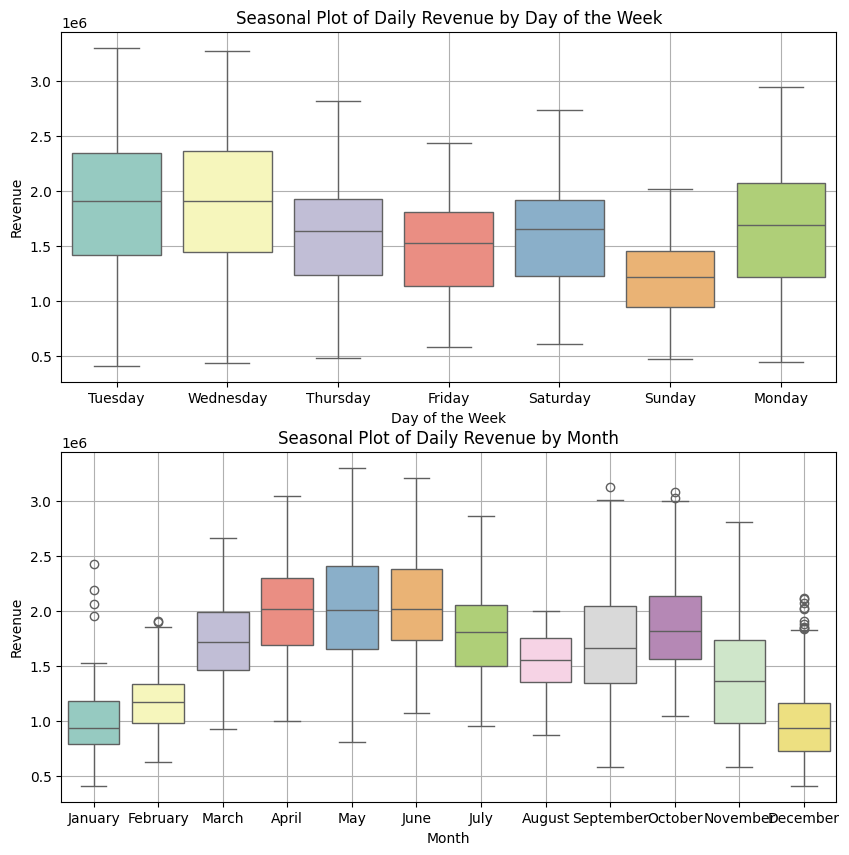

In [198]:

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
df_filtered['DayOfWeek'] = df_filtered['Date'].dt.day_name()
df_filtered['Month'] = df_filtered['Date'].dt.month_name()

sns.boxplot(x='DayOfWeek', y='Revenue', data=df_filtered, palette='Set3', ax=ax[0])
ax[0].set_title('Seasonal Plot of Daily Revenue by Day of the Week')
ax[0].set_xlabel('Day of the Week')
ax[0].set_ylabel('Revenue')
ax[0].grid(True)

sns.boxplot(x='Month', y='Revenue', data=df_filtered, palette='Set3', ax=ax[1])
ax[1].set_title('Seasonal Plot of Daily Revenue by Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Revenue')
ax[1].grid(True)

Given the columns we wanted to see if there was any correlation, which there was as expexcted given the columns we have (Demand, Occupancy, Revenue)

<AxesSubplot: >

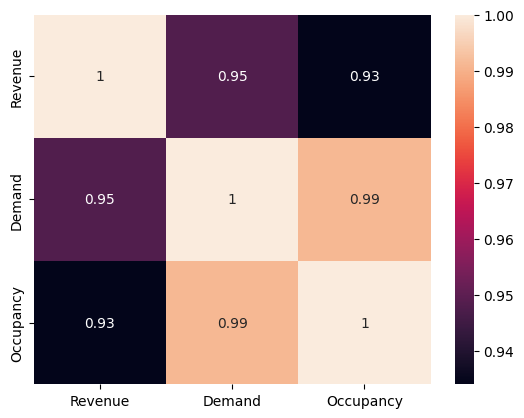

In [199]:
corr = df_filtered[["Revenue", "Demand", "Occupancy"]].corr()
sns.heatmap(corr, annot=True)

Below the plot of the aforementioned columns. As we can see, the demand and occupancy columns are practically identical, and they follow the same seasonality and trend of the Revenue one.

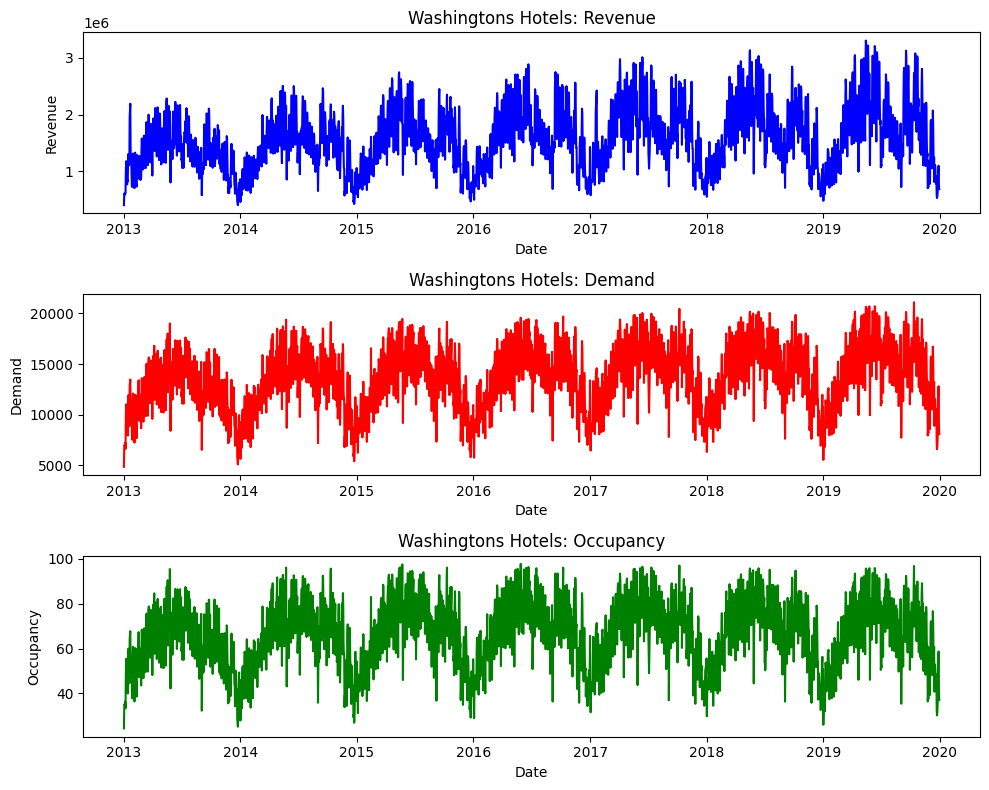

In [200]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 8))
cols = ["Revenue", "Demand", "Occupancy"]
colors = ["blue", "red", "green"]
for i, col in enumerate(cols):
    ax[i].plot(df_filtered.Date, df_filtered[col], color=colors[i])
    ax[i].set_title(f"Washingtons Hotels: {col}")
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel(col)

plt.tight_layout()
plt.show()

Apart from the classic data plotting, we wanted to perform some exploration that would give us more meaningful insights from an practical standpoint. By obtaining the Approximate Entropy, we were able to tell that there is some regularity in our data, but its not constant in time meaning that some patterns could slightly vary. This goes for all the 3 columns

In [201]:
# retrieve approximate entropy for all the series
names = ["Revenue", "Demand", "Occupancy"]
entropies = []

for name in names:
    entropy = ApEn(df_filtered[name].values, m=7)[0][3]
    entropies.append(entropy)

df_entropy = pd.DataFrame(pd.Series(entropies))
df_entropy = df_entropy.T
df_entropy.columns = names
df_entropy

,Revenue,Demand,Occupancy
0,0.906558,0.903151,0.889448


By plotting the ACF (Auto Correlation Function) plots, we gained significant insights regarding seasonality and influence of past data on the new. These plots could suggest our future need of transformations of the data in order to make them stationary.

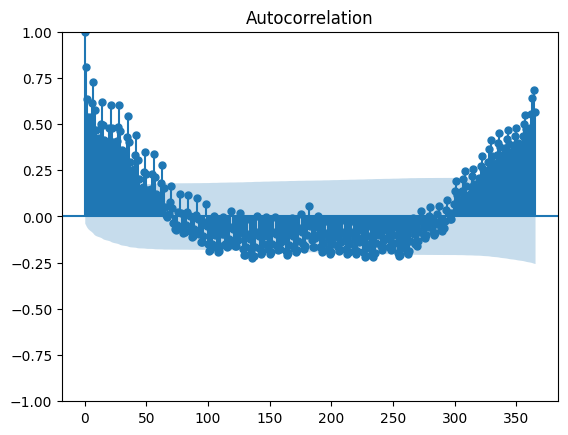

In [202]:

time_series = df_filtered['Revenue']
plot_acf(time_series, lags=365)
plt.show()

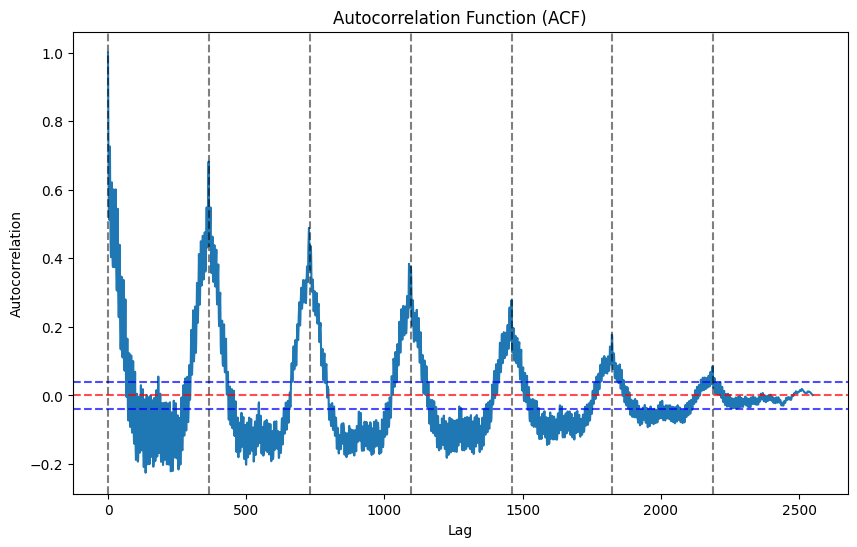

In [203]:
from statsmodels.tsa.stattools import acf

rev = df_filtered.Revenue

acf_values = acf(rev, nlags=len(rev))

plt.figure(figsize=(10, 6))
plt.plot(acf_values)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)  # Add reference line at y=0
plt.axhline(y=1.96/np.sqrt(len(rev)), color='blue', linestyle='--', alpha=0.7)
plt.axhline(y=-1.96/np.sqrt(len(rev)), color='blue', linestyle='--', alpha=0.7)  # Confidence bounds
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')

for i in range(0, len(rev), 365):
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.5)

plt.show()

Below the seasonality of our data can be furtherly confirmed by the seasonal decomposition, from which a clear pattern can be seen

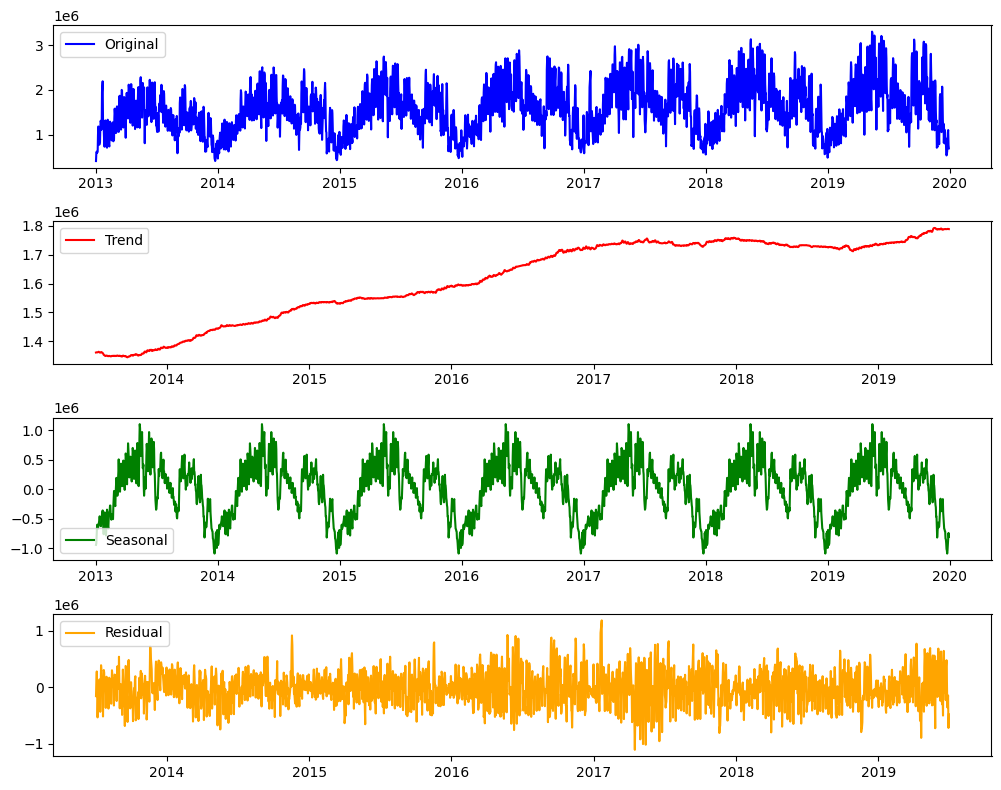

In [204]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_filtered['Revenue'], model='additive', period=365)  # Assuming a seasonal period of 30 days
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(df_filtered['Date'], df_filtered['Revenue'], label='Original', color='blue')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df_filtered['Date'], decomposition.trend, label='Trend', color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df_filtered['Date'], decomposition.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df_filtered['Date'], decomposition.resid, label='Residual', color='orange')
plt.legend()

plt.tight_layout()
plt.show()

In order to compare future models and see if the models work better with seasonal or deseasonalized data, we decided to remove the seasonal component from the data, and the plot shows how does it look now.

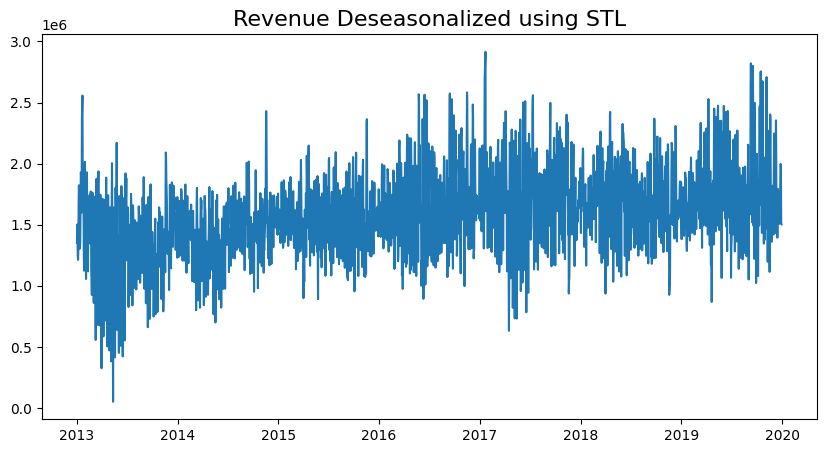

In [205]:
deseasonalized_df = df_filtered.copy()
deseasonalized_df["Revenue"] -= decomposition.seasonal

plt.figure(figsize=(10, 5))
plt.plot(deseasonalized_df["Date"], deseasonalized_df["Revenue"])
plt.title('Revenue Deseasonalized using STL', fontsize=16)
plt.plot();

One approach we chose in order to make the data more stationary was to remove the yearly average from all the values of our time series.

In [206]:
df_filtered["year"] = df_filtered["Date"].dt.year
mean_yearly = df_filtered.groupby("year")["Revenue"].mean()

detrended_yearly = df_filtered.copy()
detrended_yearly["Revenue"] = detrended_yearly["Revenue"] - detrended_yearly["year"].map(mean_yearly)

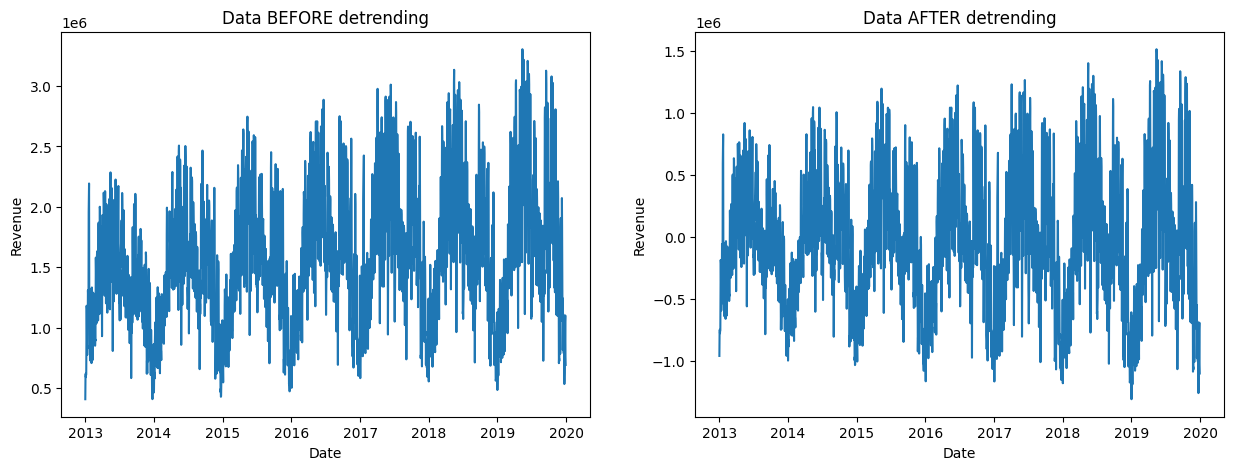

In [207]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(df_filtered.Date, df_filtered.Revenue)
ax[0].set_title("Data BEFORE detrending")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Revenue")

ax[1].plot(detrended_yearly.Date, detrended_yearly.Revenue)
ax[1].set_title("Data AFTER detrending")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Revenue");

Other detrending approach we were able to compute was the one implemented in the scipy.signal library, where we specified a "linear" type of model being the fact that our trend resembles an increasing straight line. The results in comparison to the yearly detrending we implemented manually are almost identical

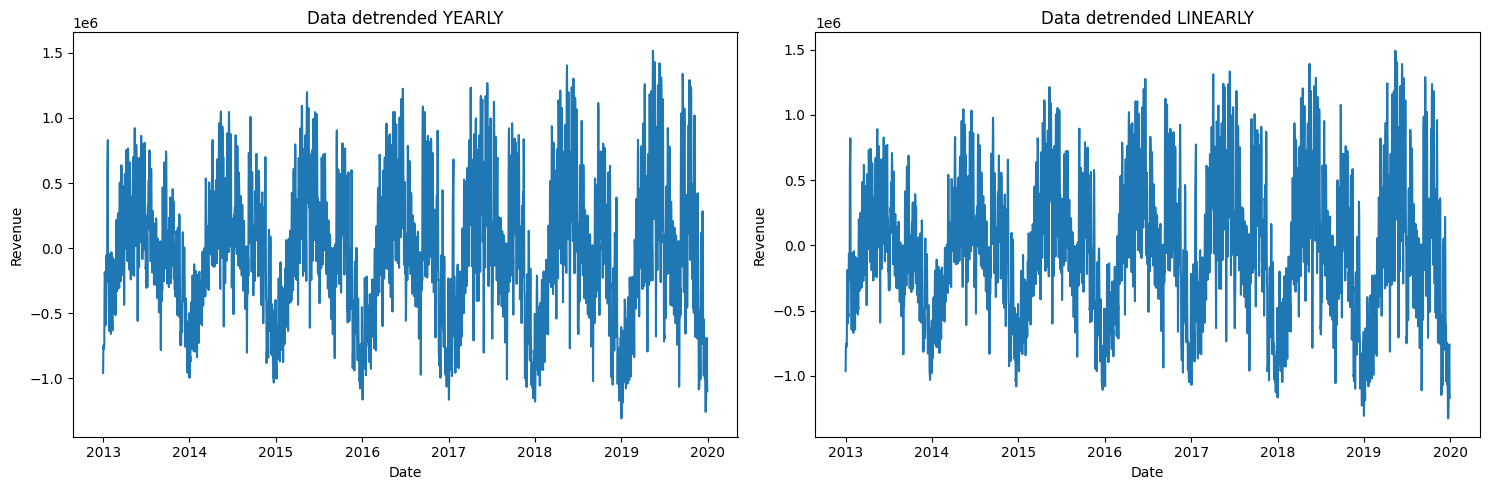

In [208]:
from scipy.signal import detrend

detrended_scipy = detrend(df_filtered['Revenue'], type="linear")
detrended_scipy = pd.Series(detrended_scipy, index=df_filtered.index)
detrended_scipy_df = df_filtered.copy()
detrended_scipy_df["Revenue"] = detrended_scipy


fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(detrended_yearly.Date, detrended_yearly.Revenue)
ax[0].set_title("Data detrended YEARLY")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Revenue")

ax[1].plot(detrended_scipy_df.Date, detrended_scipy_df.Revenue)
ax[1].set_title("Data detrended LINEARLY")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Revenue");

plt.tight_layout()
plt.show()

### DA CORREGGERE
To verify the presence of stationarity, we decided to perform two different tests: Dickey-Fuller and KPSS statistic. The results from there two tests are similar in regards to the data we detrended (yearly and linearly) and the ones we deseasonalized, whereas the two tests gave different answers of stationarity on the original data we had, where the Dickey-Fuller one affirms the data to be stationary, while KPSS states them being non stationary. 


We decided to proceed furtherly with the detrended data

In [209]:
def check_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    print(f'Result: The series is {"not " if dftest[1] > 0.05 else ""}stationary')
    
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [210]:
print("Check of stationarity: ORIGINAL\n")
check_stationarity(df_filtered.Revenue)
print('-'*30)
print("\nCheck of stationarity: DESEASONALIZED\n")
check_stationarity(deseasonalized_df.Revenue)
print('-'*30)
print("\nCheck of stationarity: YEALY DETRENDED\n")
check_stationarity(detrended_yearly.Revenue)
print('-'*30)
print("\nCheck of stationarity: LINEARLY DETRENDED\n")
check_stationarity(detrended_scipy_df.Revenue)

Check of stationarity: ORIGINAL

Results of Dickey-Fuller Test:
Test Statistic                   -3.252582
p-value                           0.017136
#Lags Used                       27.000000
Number of Observations Used    2522.000000
Critical Value (1%)              -3.432946
Critical Value (5%)              -2.862687
Critical Value (10%)             -2.567380
dtype: float64
Result: The series is stationary
------------------------------

Check of stationarity: DESEASONALIZED

Results of Dickey-Fuller Test:
Test Statistic                   -2.835244
p-value                           0.053413
#Lags Used                       27.000000
Number of Observations Used    2522.000000
Critical Value (1%)              -3.432946
Critical Value (5%)              -2.862687
Critical Value (10%)             -2.567380
dtype: float64
Result: The series is not stationary
------------------------------

Check of stationarity: YEALY DETRENDED

Results of Dickey-Fuller Test:
Test Statistic               

In [211]:
print("Check of stationarity: ORIGINAL\n")
kpss_test(df_filtered.Revenue)
print('-'*30)
print("\nCheck of stationarity: DESEASONALIZED\n")
kpss_test(deseasonalized_df.Revenue)
print('-'*30)
print("\nCheck of stationarity: YEALY DETRENDED\n")
kpss_test(detrended_yearly.Revenue)
print('-'*30)
print("\nCheck of stationarity: LINEARLY DETRENDED\n")
kpss_test(detrended_scipy_df.Revenue)

Check of stationarity: ORIGINAL

KPSS Statistic: 1.1424236288610563
p-value: 0.01
num lags: 27
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
------------------------------

Check of stationarity: DESEASONALIZED

KPSS Statistic: 9.704730057520068
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
------------------------------

Check of stationarity: YEALY DETRENDED

KPSS Statistic: 0.03536457487339616
p-value: 0.1
num lags: 27
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
------------------------------

Check of stationarity: LINEARLY DETRENDED

KPSS Statistic: 0.05480184694923858
p-value: 0.1
num lags: 27
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


## Model Building

In [ ]:
def xy_to_reshape(series, window_x, window_y):
    
    total_data_points = len(series) - window_x + 1

    x_data = []
    y_data = []

    for i in range(total_data_points):
        x = series[i:i+window_x]
        y = series[i+window_x:i+window_x+window_y]
        
        if len(x) == window_x and len(y) == window_y:
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data).astype(np.float32), np.array(y_data).astype(np.float32)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def model_predict(x, y):
    predictions = []
    for i in range(y.shape[0]):
        model = ARIMA(x[i, :], order=(2, 1, 1), seasonal_order=(1, 1, 0, 365))
        pred = model.fit().forecast(steps=y.shape[1])
        predictions.append(pred)

        print(f"Progress: {i}/{y.shape[0]}", end="\r")

    return np.array(predictions)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# divide in train and test set the revenue column
train = df_filtered.Revenue.iloc[:int(len(df_filtered)*0.8)].values
test = df_filtered.Revenue.iloc[int(len(df_filtered)*0.8):].values
test = pd.Series(test)
train = pd.Series(train)
print(train.shape, test.shape)

(2040,) (510,)


In [ ]:
condition = True
history = 1500
serie = df_filtered.Revenue.values[:int(len(df_filtered)*0.6)]

results = []

while condition:
    x_test, y_test = xy_to_reshape(serie, history, 7)

    # fix a maximum ammount of rows
    if x_test.shape[0] > 365:
        # sample 500 random samples from xtest and y test
        idx = np.random.choice(x_test.shape[0], 365, replace=False)
        x_test = x_test[idx]
        y_test = y_test[idx]

    print(x_test.shape, y_test.shape)

    preds = model_predict(x_test, y_test)

    rmses = []
    for i in range(7):
        rmses.append(rmse(y_test[:, i], preds[:, i]))

    print(history, np.mean(rmses))
    results.append([np.mean(rmses), history])


    history = history / 100 * 60
    history = int(history)

    if history < 30:
        condition = False
    


(24, 1500) (24, 7)


KeyboardInterrupt: 

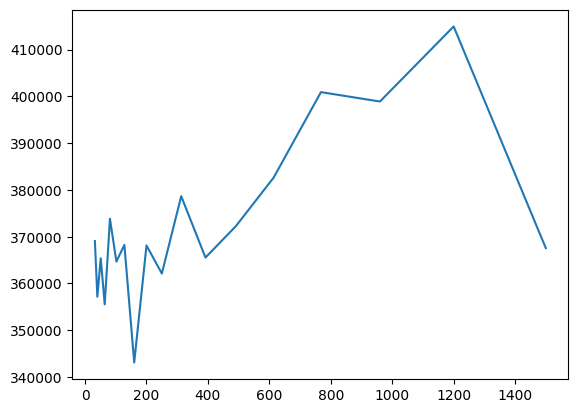

In [ ]:
results = pd.DataFrame(results, columns=["RMSE", "History"])

plt.plot(results.History, results.RMSE)

In [ ]:
def cast_df(y, df):
    h = len(y)
    return pd.DataFrame(y, index=np.arange(len(df), len(df)+h))

p=365
# code the three naive methods that we've seen
naive = lambda x, h: cast_df(np.tile(x.iloc[-1], h), x)
mean = lambda x, h: cast_df(np.tile(x.mean(), h), x)
seasonal = lambda x, h: cast_df(np.tile(x.iloc[-p:].values.ravel() -x.iloc[-p:].values[0]+x.iloc[-p:].values[-1],
                                        int(np.ceil(h/p)))[:h], x)

# predict the last 7 days for each method 
steps_ahead = 7

naive_preds = []
mean_preds = []
seasonal_preds = []

for i in range(len(y_data)):
    naive_pred = naive(pd.Series(y_data[i]), steps_ahead)
    mean_pred = mean(pd.Series(y_data[i]), steps_ahead)
    seasonal_pred = seasonal(pd.Series(y_data[i]), steps_ahead)
    
    naive_preds.append(naive_pred)
    mean_preds.append(mean_pred)
    seasonal_preds.append(seasonal_pred)

NameError: name 'y_data' is not defined

In [ ]:
naive_preds = np.array(naive_preds).reshape(len(x_data), 7)
mean_preds = np.array(mean_preds).reshape(len(x_data), 7)
seasonal_preds = np.array(seasonal_preds).reshape(len(x_data), 7)

In [ ]:
naive_pred = naive(df_filtered["Revenue"], steps_ahead)
mean_pred = mean(df_filtered["Revenue"], steps_ahead)
seasonal_pred = seasonal(df_filtered["Revenue"], steps_ahead)

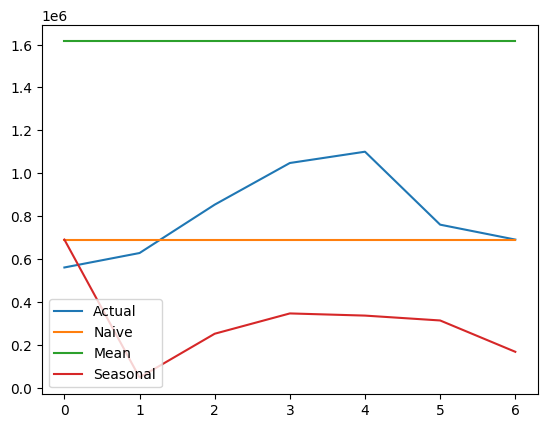

In [ ]:
plt.plot(df_filtered.Revenue[-7:].values, label="Actual")
plt.plot(naive_pred.values, label="Naive")
plt.plot(mean_pred.values, label="Mean")
plt.plot(seasonal_pred.values, label="Seasonal")
plt.legend()

In [ ]:
nmae = lambda x, y: np.mean(np.abs(x-y)) / np.mean(np.abs(y))
def nmae1(x, y):
    result = np.sum(np.abs(x-y)) / np.sum(np.abs(y))
    return result



naive_nmae = nmae(df_filtered[-steps_ahead:].Revenue, naive_pred[0].values)
mean_nmae = nmae(df_filtered[-steps_ahead:].Revenue, mean_pred[0].values)
seasonal_nmae = nmae(df_filtered[-steps_ahead:].Revenue, seasonal_pred[0].values)
seasonal_nmae1 = nmae1(df_filtered[-steps_ahead:].Revenue, seasonal_pred[0].values)

print(f"Naive NMAE: {round(naive_nmae, 3)}")
print(f"Mean NMAE: {round(mean_nmae, 3)}")
print(f"Seasonal NMAE: {round(seasonal_nmae, 3)}")
print(f"Seasonal NMAE: {round(seasonal_nmae1, 3)}")

Naive NMAE: 0.247
Mean NMAE: 0.501
Seasonal NMAE: 1.742
Seasonal NMAE: 1.742


## Holt Smothing

In [222]:
def holt_smoothing(y, h=1, alpha=0.1, beta=0.2):
  l, l_past = y.iloc[0], y.iloc[0]
  b = 0
  for y_i in y.values:
    l = alpha*y_i + (1-alpha)*(l_past+b)
    b = beta*(l-l_past) + (1-beta)*b
    l_past = l

  return l + b*np.arange(h)

holt_preds = []
for i in range(len(y_data)):
    holt_pred = holt_smoothing(pd.Series(y_data[i]), 3, alpha=0.1, beta=0.2)
    holt_preds.append(holt_pred)

In [223]:
holt_preds = np.array(holt_preds)
holt_preds.shape

(2514, 3)

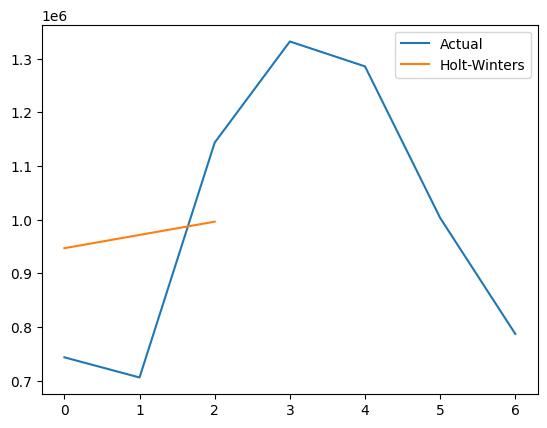

In [224]:
plt.plot(y_data[1], label="Actual")
plt.plot(holt_preds[1], label="Holt-Winters")
plt.legend()

## Smoothing Optimization

In [225]:
results = []
alphas = np.linspace(0, 1, 11)
betas = np.linspace(0, 1, 11)

# for each combination of alpha and beta, calculate the NMAE on holt predictions
for alpha in alphas:
    for beta in betas:
        holt_preds = []
        for i in range(len(y_data)):
            holt_pred = holt_smoothing(pd.Series(y_data[i]), steps_ahead, alpha=alpha, beta=beta)
            holt_preds.append(holt_pred)

        holt_preds = np.array(holt_preds)
        nmae_holt = nmae(y_data, holt_preds)
        results.append([alpha, beta, nmae_holt])

results = pd.DataFrame(results, columns=["Alpha", "Beta", "NMAE"])
results

,Alpha,Beta,NMAE
0,0.0,0.0,0.203844
1,0.0,0.1,0.203844
2,0.0,0.2,0.203844
3,0.0,0.3,0.203844
4,0.0,0.4,0.203844
...,...,...,...
116,1.0,0.6,0.486287
117,1.0,0.7,0.518568
118,1.0,0.8,0.546099
119,1.0,0.9,0.570003


In [226]:
# take the rows of results with the lowest NMAE
best_params = results.loc[results["NMAE"].idxmin()]
best_params

Alpha    0.100000
Beta     0.200000
NMAE     0.140729
Name: 13, dtype: float64